Iniciando Proceso de ML Completo...
DataManager inicializado con el archivo: /content/drive/MyDrive/Pregrado - Posgrado - Trabajo/Maestría - Inteligencia Artificial Aplicada/11. MLOps/1. Primera etapa de proyecto/Modelado/obesity_estimation_original.csv
Iniciando carga y limpieza de datos...
Se eliminaron 24 duplicados.
No se encontraron columnas 100% nulas.
Carga y limpieza de datos completada.
Dividiendo datos en entrenamiento y prueba...
Codificando variable objetivo...
 INICIANDO ENTRENAMIENTO PARA: KNN
Preprocesador: 8 features numéricas y 8 categóricas.
Iniciando RandomizedSearchCV para KNeighborsClassifier...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Búsqueda completada para KNeighborsClassifier.

--- RESULTADOS FINALES: KNN ---
Mejores Hiperparámetros:
{'classifier__metric': 'manhattan', 'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}

Mejor puntaje CV (Accuracy): 0.8610
Precisión final en Test: 0.8612

Evaluador listo para el modelo: KNeigh

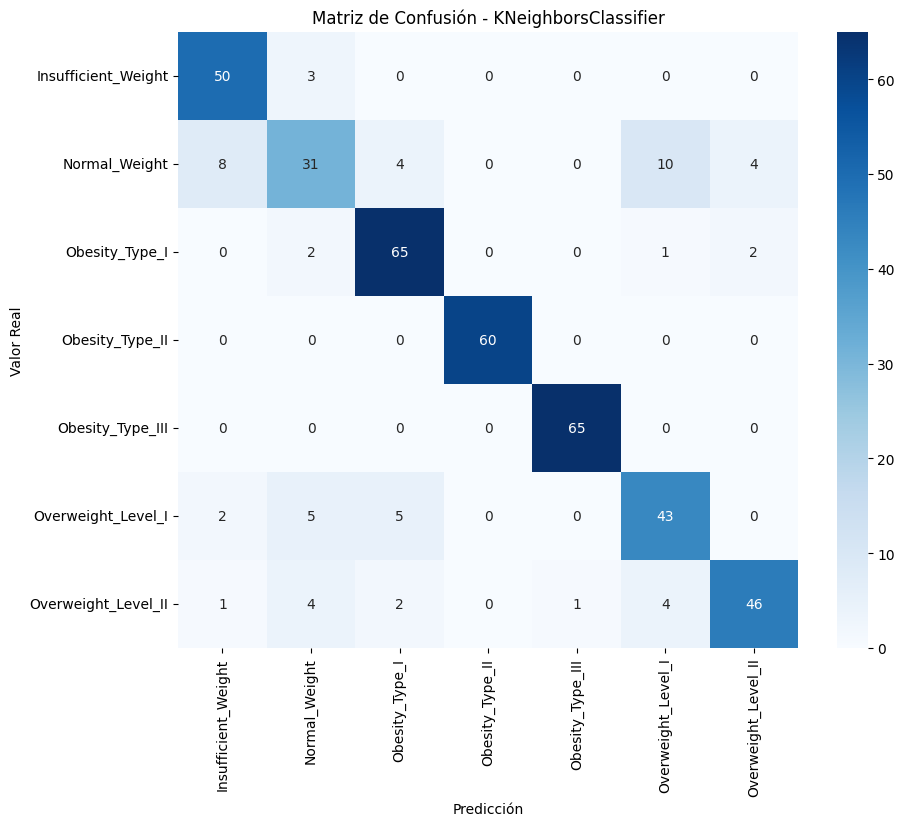


ROC AUC Score (One-vs-Rest): 0.9605


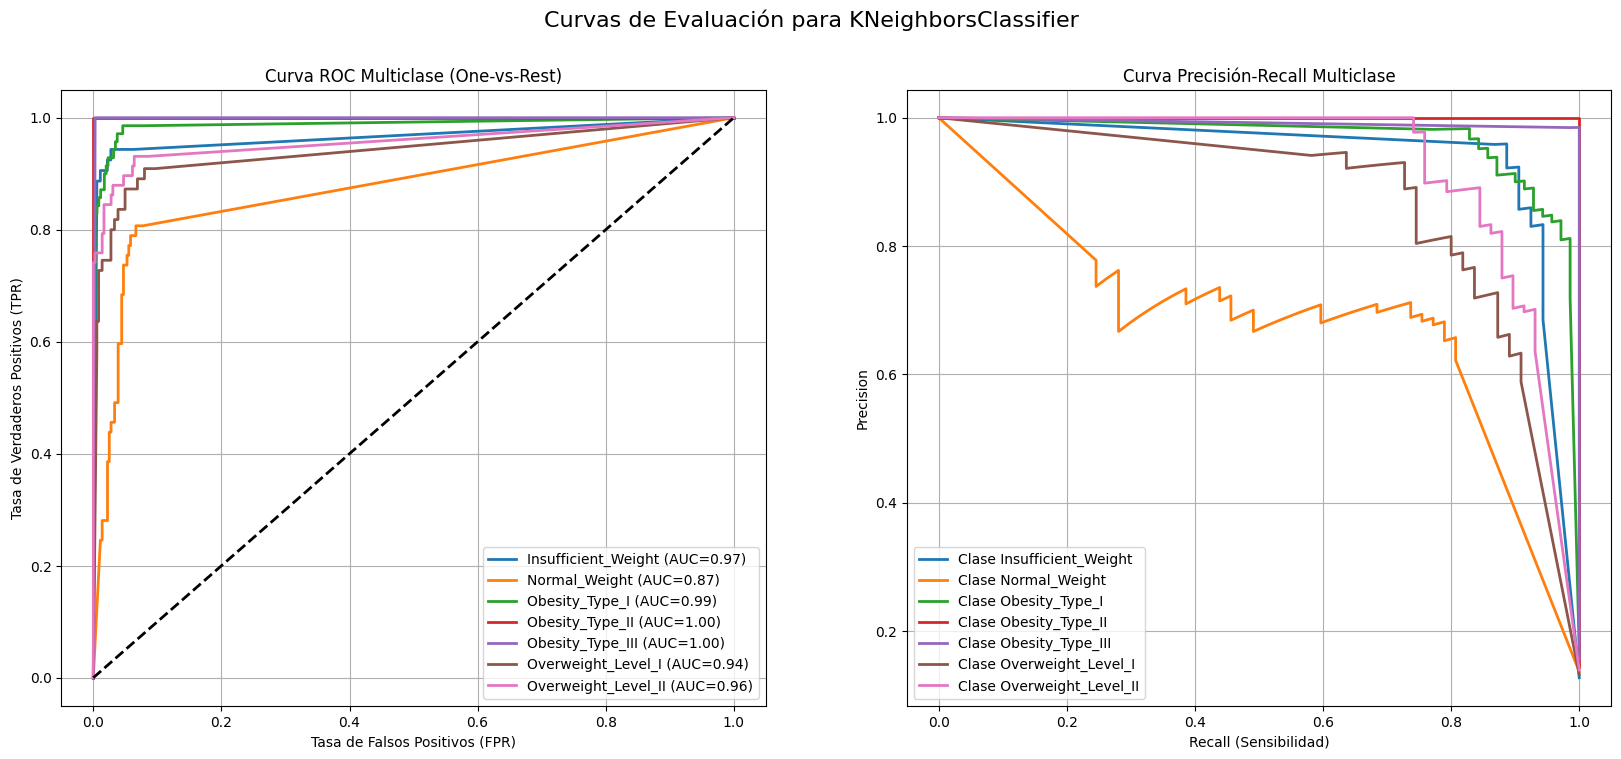


--- INTERPRETACIÓN DEL MODELO ---

El modelo seleccionado (KNeighborsClassifier) no tiene 'feature_importances_'.
 INICIANDO ENTRENAMIENTO PARA: Random Forest
Iniciando RandomizedSearchCV para RandomForestClassifier...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Búsqueda completada para RandomForestClassifier.

--- RESULTADOS FINALES: Random Forest ---
Mejores Hiperparámetros:
{'classifier__max_depth': 21, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 323}

Mejor puntaje CV (Accuracy): 0.9377
Precisión final en Test: 0.9498

Evaluador listo para el modelo: RandomForestClassifier

--- EVALUACIÓN DETALLADA EN TEST ---

--- Reporte de Clasificación ---
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.94      0.97        53
      Normal_Weight       0.79      0.95      0.86        57
     Obesity_Type_I       1.00      0.97      0.99

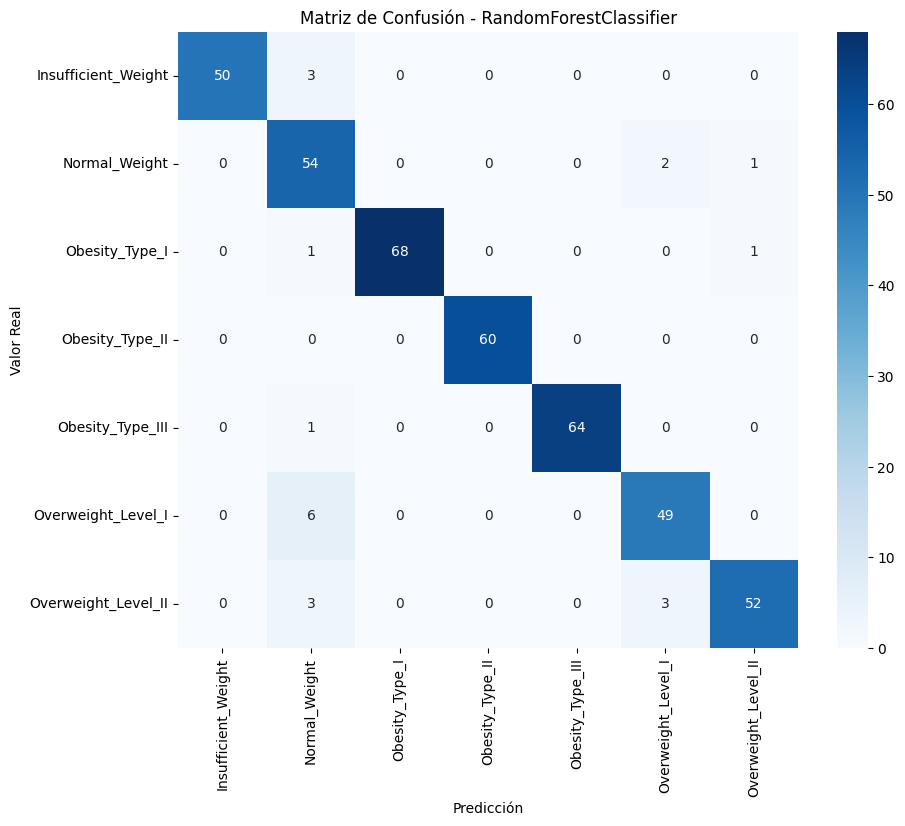


ROC AUC Score (One-vs-Rest): 0.9940


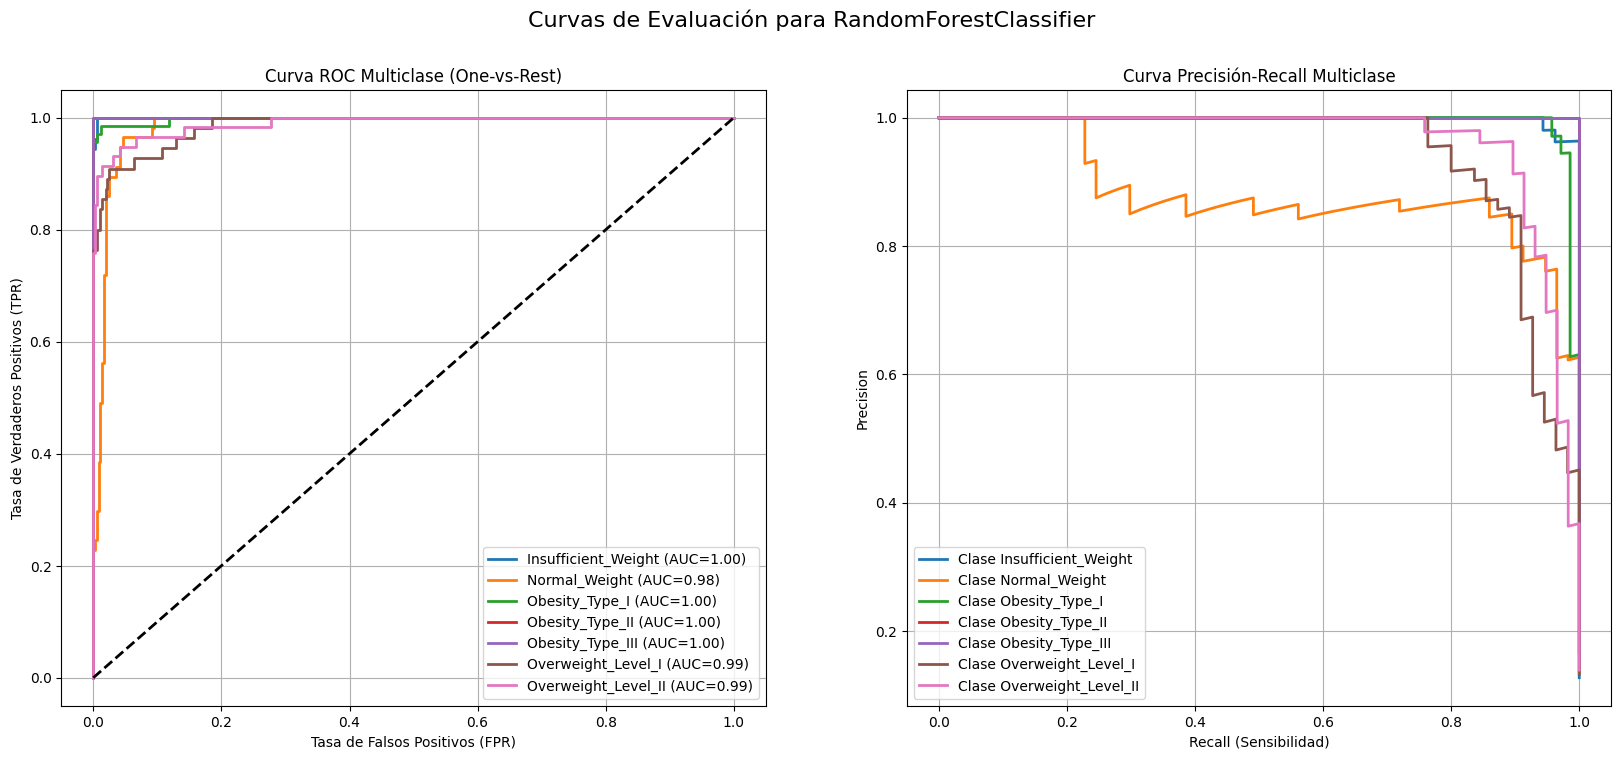


--- INTERPRETACIÓN DEL MODELO ---

--- Importancia de Variables ---


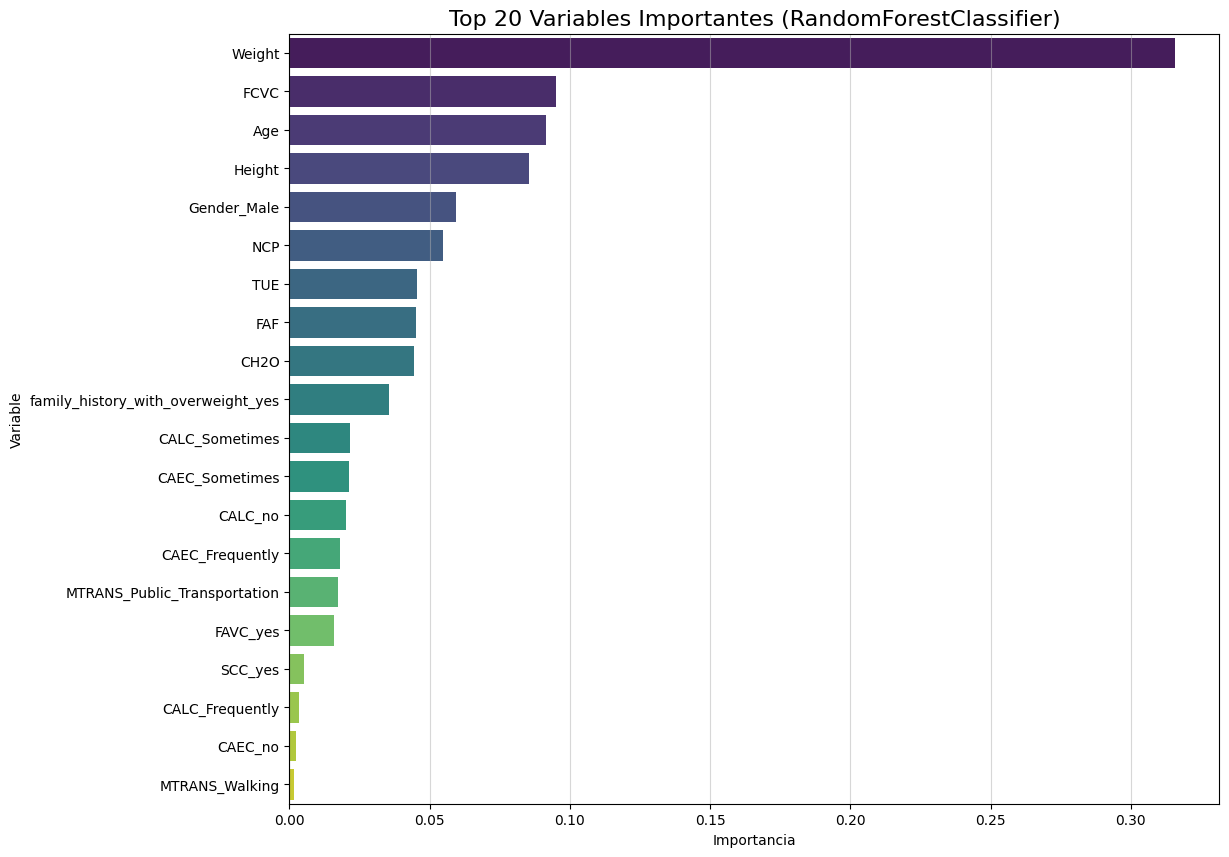

 INICIANDO ENTRENAMIENTO PARA: XGBoost
Iniciando RandomizedSearchCV para XGBClassifier...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Búsqueda completada para XGBClassifier.

--- RESULTADOS FINALES: XGBoost ---
Mejores Hiperparámetros:
{'classifier__colsample_bytree': np.float64(0.9521871356061031), 'classifier__learning_rate': np.float64(0.197306214440138), 'classifier__max_depth': 8, 'classifier__n_estimators': 233, 'classifier__subsample': np.float64(0.782613828193164)}

Mejor puntaje CV (Accuracy): 0.9670
Precisión final en Test: 0.9737

Evaluador listo para el modelo: XGBClassifier

--- EVALUACIÓN DETALLADA EN TEST ---

--- Reporte de Clasificación ---
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      1.00      1.00        53
      Normal_Weight       0.93      0.95      0.94        57
     Obesity_Type_I       1.00      0.97      0.99        70
    Obesity_Type_II       0.97      1.00      0.98        60
   Obesity

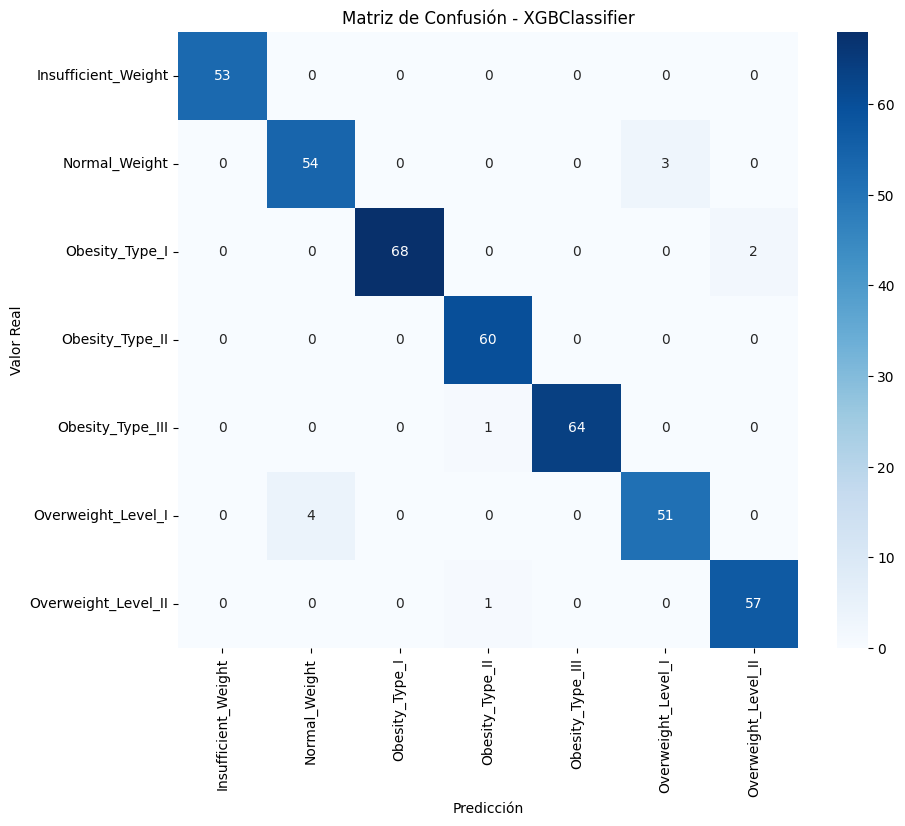


ROC AUC Score (One-vs-Rest): 0.9995


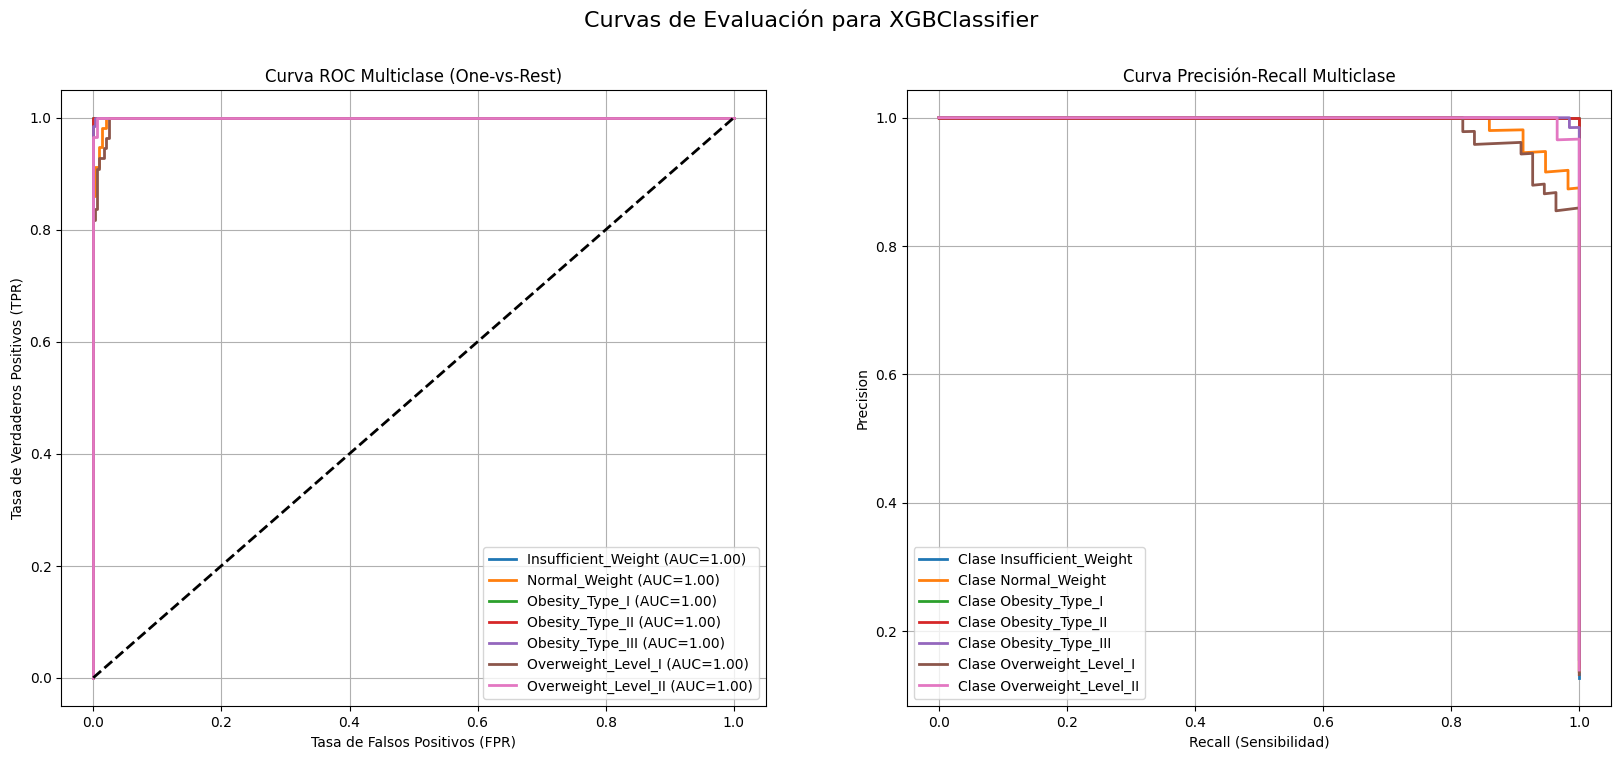


--- INTERPRETACIÓN DEL MODELO ---

--- Importancia de Variables ---


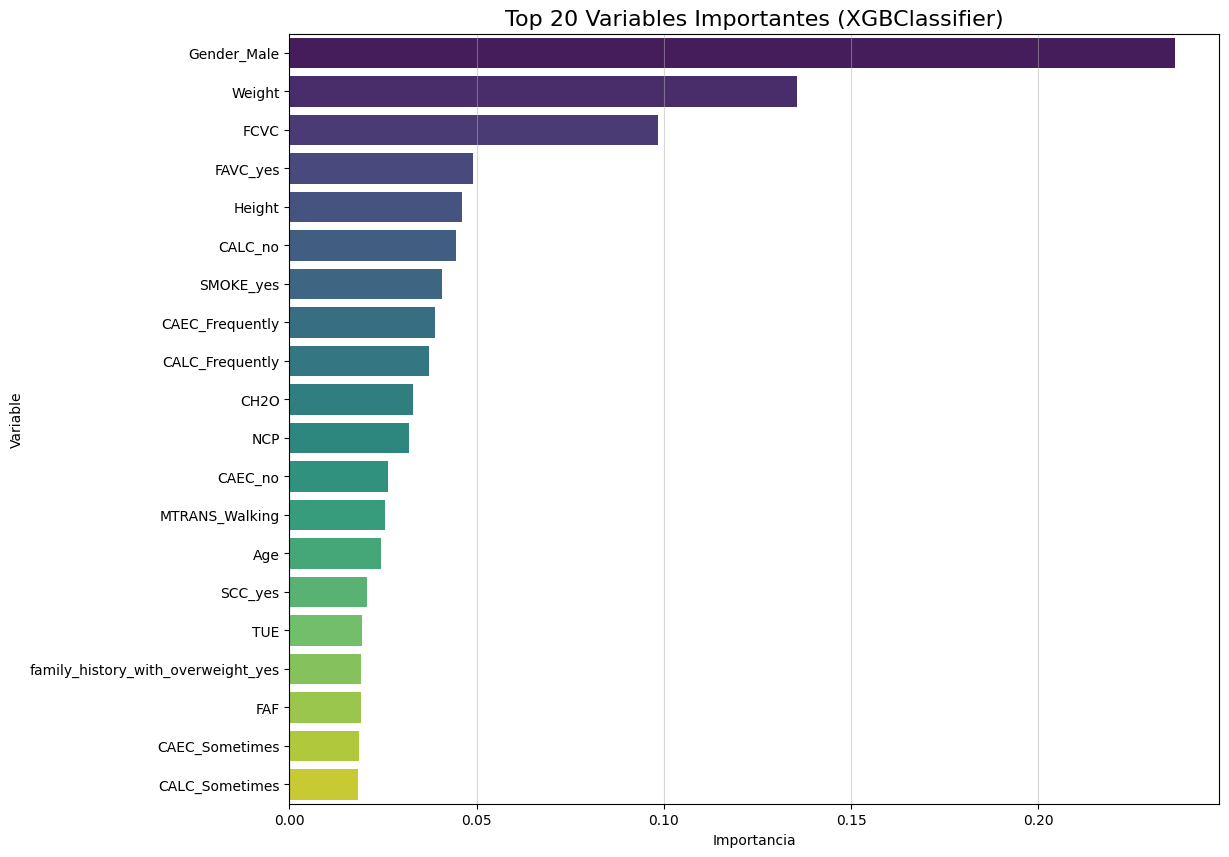

Generando gráficos de Dependencia Parcial (PDP) para XGBoost...

--- Generando Curvas de Dependencia Parcial para: ['Age', 'Height', 'Weight'] ---


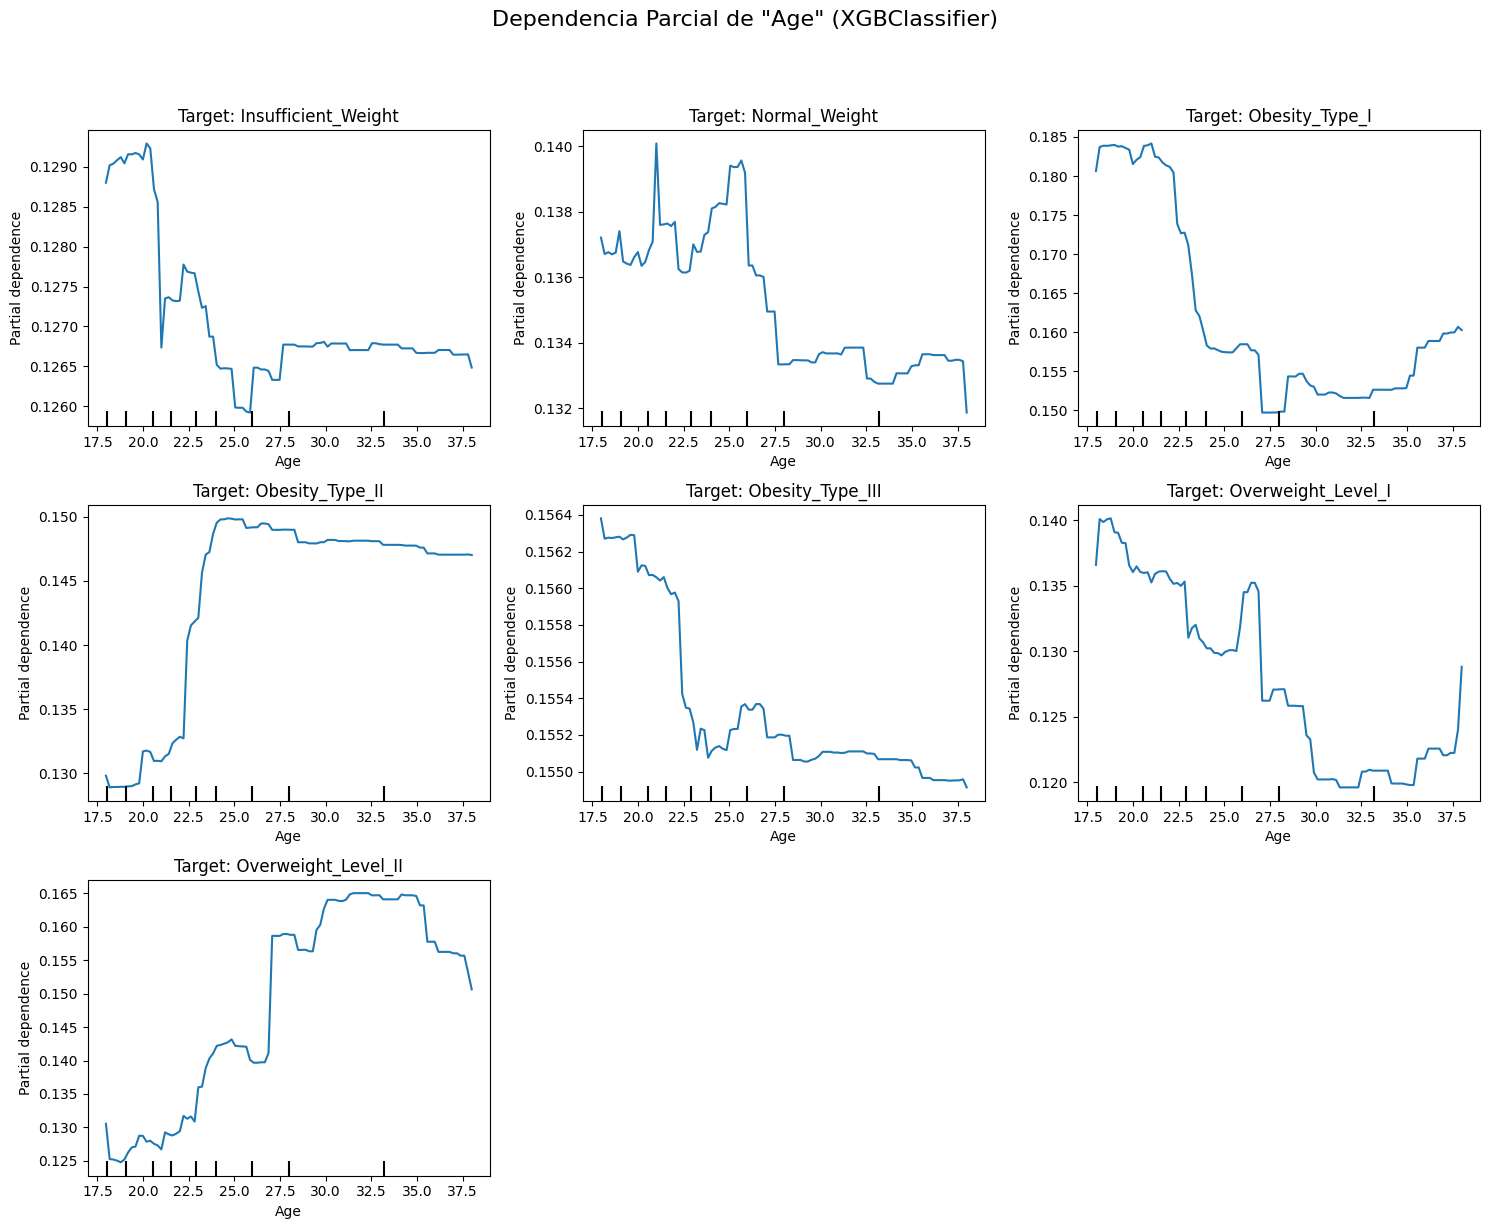

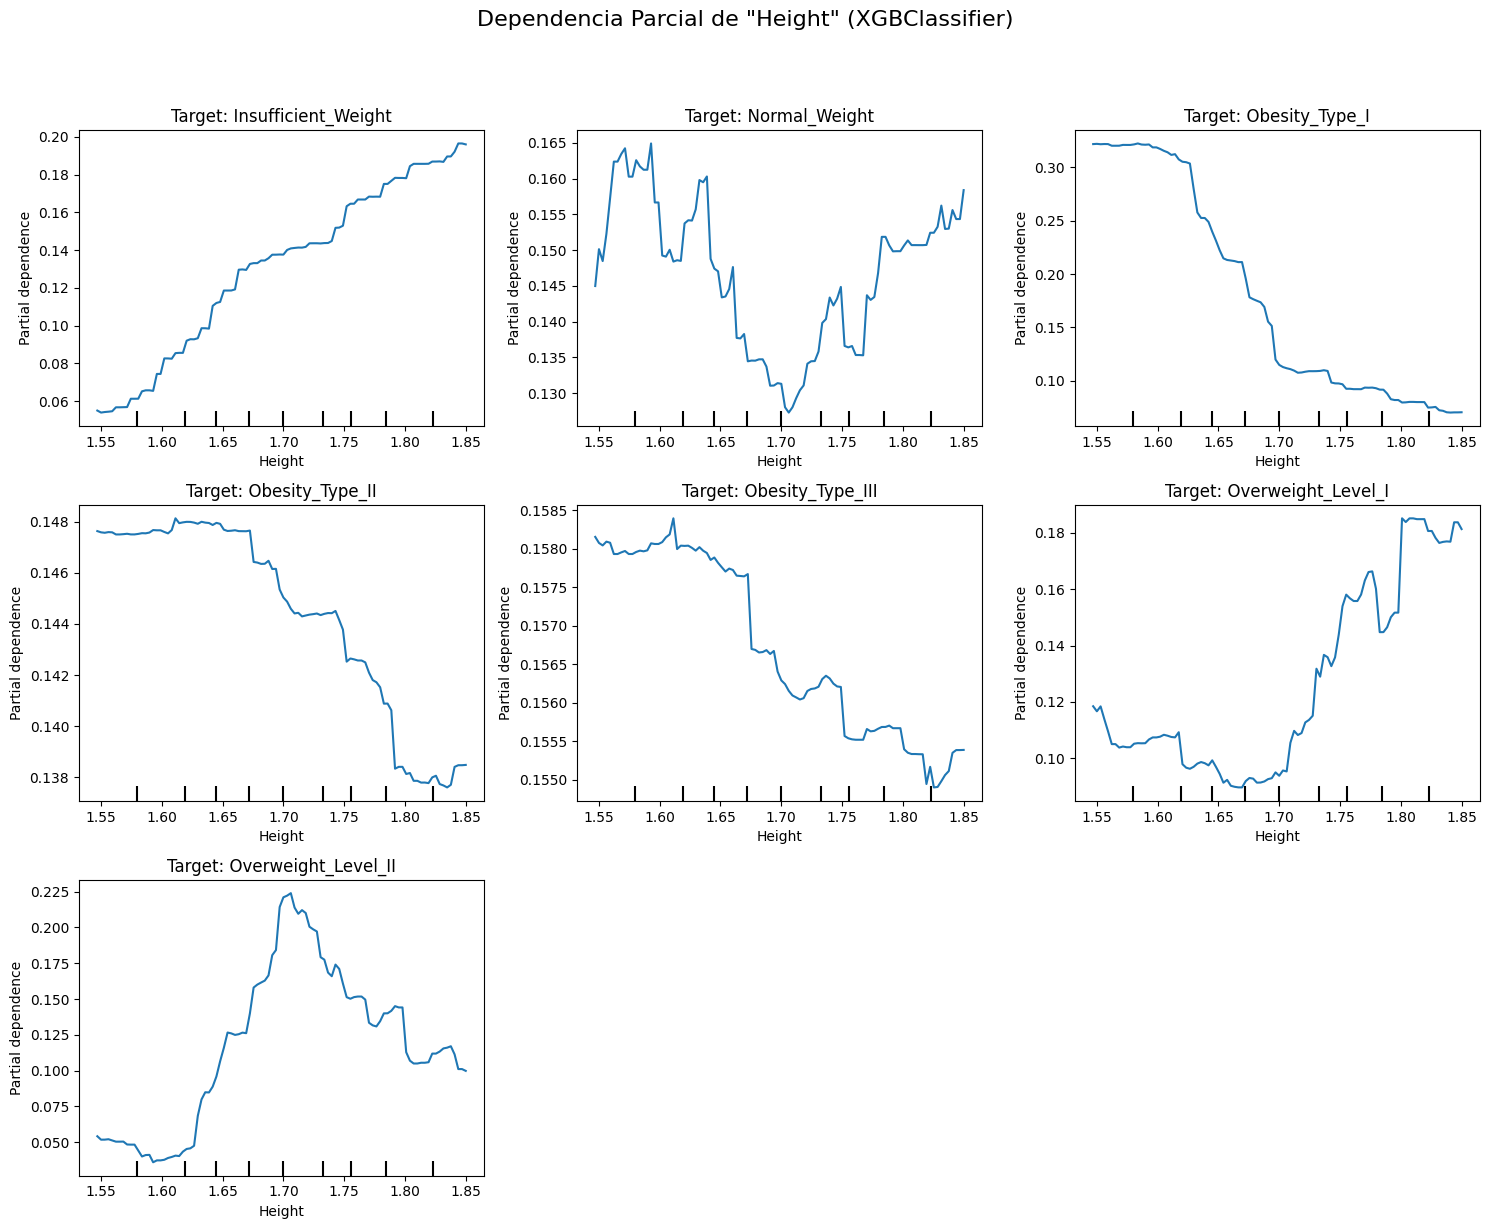

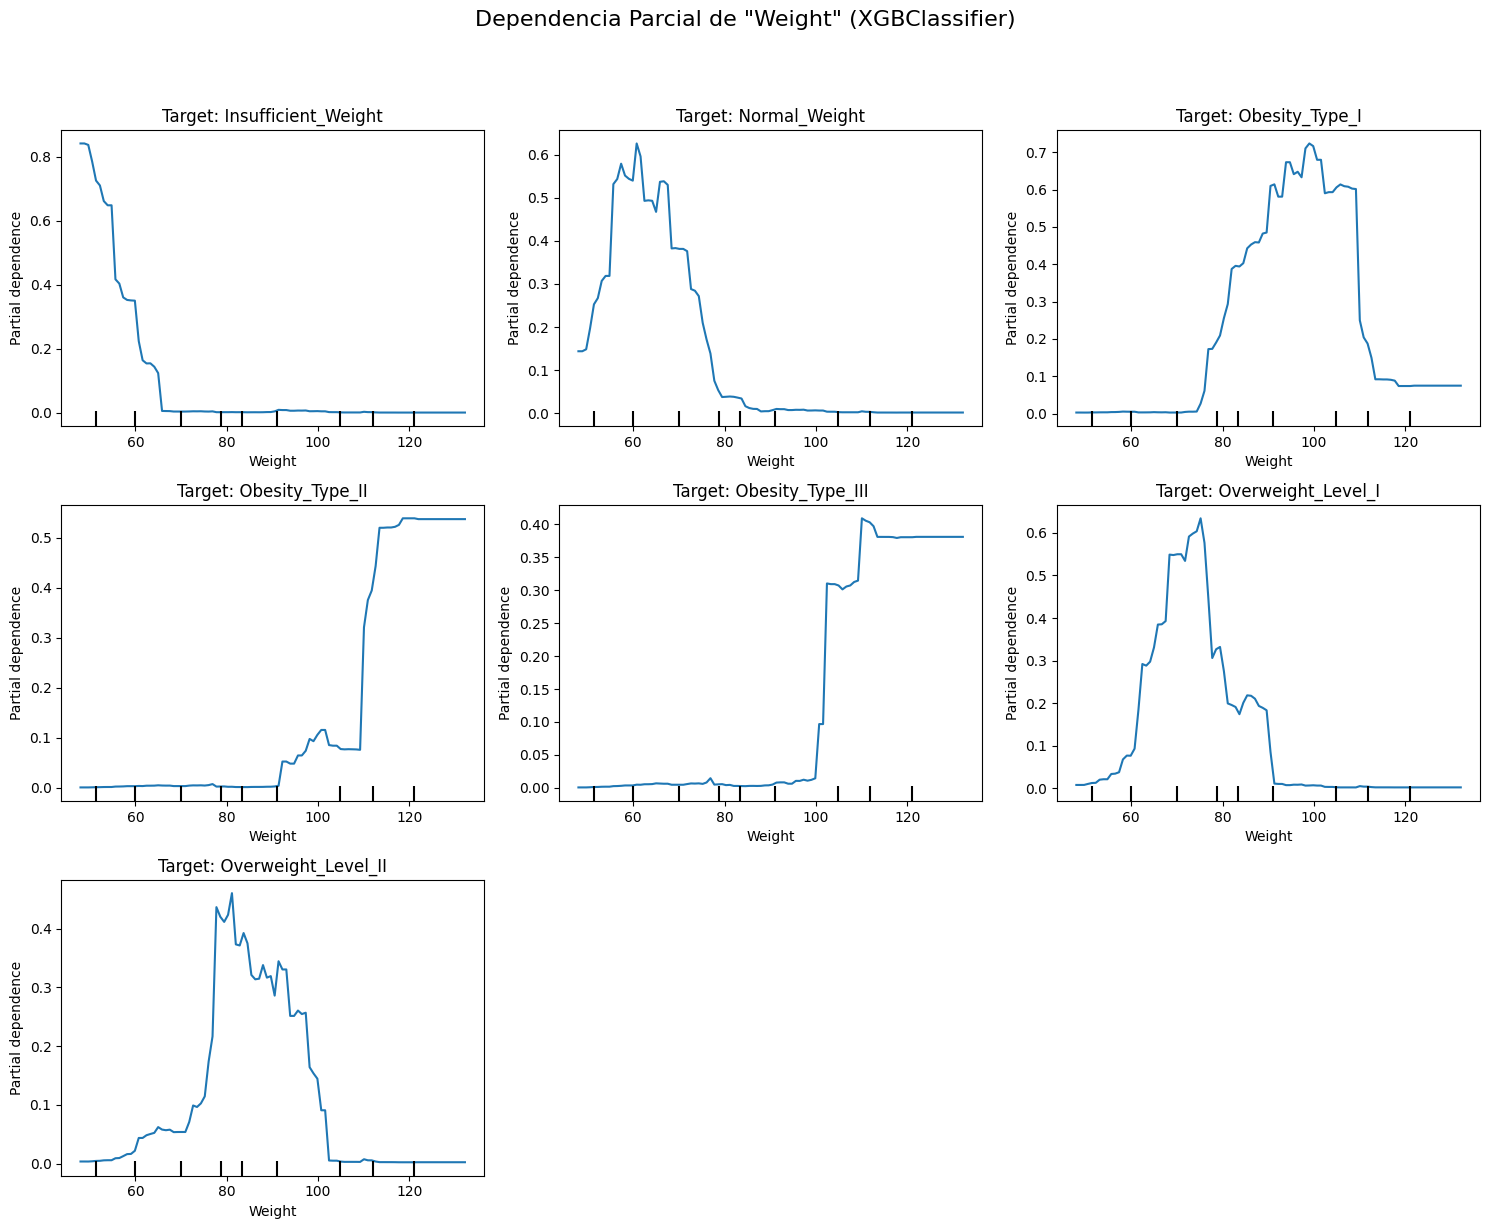

Proceso de ML Completo Finalizado.


In [2]:
# =============================================================================
# 1. IMPORTACIONES
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import randint, uniform

# Preprocesamiento y Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Métricas y Evaluación
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, auc, precision_recall_curve
)
from sklearn.preprocessing import label_binarize
from sklearn.inspection import PartialDependenceDisplay

# Ignorar advertencias para una salida más limpia (opcional)
import warnings
warnings.filterwarnings('ignore')


# =============================================================================
# 2. CLASE DE GESTIÓN DE DATOS
# (Idealmente, esto iría en un archivo: data_manager.py)
# =============================================================================

class DataManager:
    """
    Encapsula la carga, limpieza y preparación de los datos.
    """
    def __init__(self, file_path, sep=None):
        """
        Inicializa el gestor de datos.

        :param file_path: Ruta al archivo CSV.
        :param sep: Separador del CSV (opcional).
        """
        self.file_path = file_path
        self.sep = sep
        print(f"DataManager inicializado con el archivo: {file_path}")

    def load_and_clean_data(self):
        """
        Carga el dataset, lo limpia y elimina duplicados y columnas nulas.
        """
        print("Iniciando carga y limpieza de datos...")
        # Cargar dataset original
        df_raw = pd.read_csv(self.file_path, sep=self.sep, engine="python", encoding="utf-8")
        df = df_raw.copy()

        # Estandarizar nulos y espacios
        df = df.replace(r"^\s*$", np.nan, regex=True)
        df = df.replace({"NA": np.nan, "N/A": np.nan, "na": np.nan, "NaN": np.nan})

        # Recortar strings
        obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
        for c in obj_cols:
            df[c] = df[c].astype(str).str.strip()

        # Eliminar duplicados
        duplicates_before = df.duplicated().sum()
        df = df.drop_duplicates()
        print(f"Se eliminaron {duplicates_before} duplicados.")

        # Eliminar columnas 100% nulas
        all_null = [c for c in df.columns if df[c].isna().all()]
        if all_null:
            df = df.drop(columns=all_null)
            print(f"Columnas eliminadas (100% nulas): {all_null}")
        else:
            print("No se encontraron columnas 100% nulas.")


        print("Carga y limpieza de datos completada.")
        return df

    def split_data(self, df, target_col, test_size=0.2, random_state=42):
        """
        Divide los datos en características (X) y objetivo (y),
        y luego en conjuntos de entrenamiento y prueba.

        :param df: DataFrame limpio.
        :param target_col: Nombre de la columna objetivo.
        :param test_size: Proporción del dataset para el conjunto de prueba.
        :param random_state: Semilla para reproducibilidad.
        :return: X_train, X_test, y_train, y_test
        """
        print("Dividiendo datos en entrenamiento y prueba...")
        X = df.drop(target_col, axis=1)
        y = df[target_col]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        return X_train, X_test, y_train, y_test

    def encode_target(self, y_train, y_test):
        """
        Codifica la variable objetivo (y) usando LabelEncoder.

        :param y_train: Objetivo de entrenamiento.
        :param y_test: Objetivo de prueba.
        :return: y_train_encoded, y_test_encoded, label_encoder (el objeto ajustado)
        """
        print("Codificando variable objetivo...")
        label_encoder = LabelEncoder()
        y_train_encoded = label_encoder.fit_transform(y_train)
        y_test_encoded = label_encoder.transform(y_test)
        return y_train_encoded, y_test_encoded, label_encoder


# =============================================================================
# 3. CLASE DE FÁBRICA DE PIPELINES
# =============================================================================

class ModelPipelineFactory:
    """
    Construye y entrena pipelines de modelo con búsqueda de hiperparámetros.
    """
    def __init__(self):
        self.preprocessor = None

    def _create_preprocessor(self, X_train):
        """
        Crea un preprocesador (ColumnTransformer) basado en los tipos de
        columnas de X_train.

        :param X_train: DataFrame de características de entrenamiento.
        :return: Objeto ColumnTransformer.
        """
        # Identificar tipos de columnas desde X_train
        numeric_features = X_train.select_dtypes(include=np.number).columns
        categorical_features = X_train.select_dtypes(
            include=['object', 'category']
        ).columns

        print(f"Preprocesador: {len(numeric_features)} features numéricas y {len(categorical_features)} categóricas.")

        # Pipeline para variables numéricas
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value=-20)),
            ('scaler', RobustScaler())
        ])

        # Pipeline para variables categóricas
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
            ('onehot', OneHotEncoder(
                handle_unknown='ignore', sparse_output=False, drop='first'
            ))
        ])

        # Crear el ColumnTransformer
        self.preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ], remainder='passthrough')

        return self.preprocessor

    def create_and_tune_model(self, X_train, y_train, classifier, param_grid, search_options):
        """
        Crea un pipeline completo y lo entrena usando RandomizedSearchCV.

        :param X_train: Características de entrenamiento.
        :param y_train: Objetivo de entrenamiento (codificado).
        :param classifier: El objeto clasificador (ej. XGBClassifier()).
        :param param_grid: Diccionario de hiperparámetros para la búsqueda.
        :param search_options: Diccionario de opciones para RandomizedSearchCV.
        :return: Objeto RandomizedSearchCV ajustado.
        """

        # 1. Crear el preprocesador si aún no existe
        if self.preprocessor is None:
            self.preprocessor = self._create_preprocessor(X_train)

        # 2. Crear el pipeline principal
        model_pipeline = Pipeline(steps=[
            ('preprocessor', self.preprocessor),
            ('classifier', classifier)
        ])

        # 3. Configurar y ejecutar la búsqueda aleatoria
        random_search = RandomizedSearchCV(
            model_pipeline,
            param_distributions=param_grid,
            **search_options  # Desempaqueta n_iter, cv, scoring, etc.
        )

        model_name = classifier.__class__.__name__
        print(f"Iniciando RandomizedSearchCV para {model_name}...")
        random_search.fit(X_train, y_train)
        print(f"Búsqueda completada para {model_name}.")

        return random_search


# =============================================================================
# 4. CLASE DE EVALUACIÓN DE MODELOS
# =============================================================================

class ModelEvaluator:
    """
    Encapsula la evaluación e interpretación de un modelo entrenado.
    """
    def __init__(self, best_model, X_test, y_test_original, y_test_encoded, label_encoder):
        """
        Inicializa el evaluador con el modelo y los datos de prueba.
        """
        self.model = best_model
        self.X_test = X_test
        self.y_test_original = y_test_original # 'y_test' (strings)
        self.y_test_encoded = y_test_encoded # 'y_test_encoded' (números)
        self.le = label_encoder
        self.class_labels = self.le.classes_
        self.model_name = self.model.named_steps['classifier'].__class__.__name__
        print(f"Evaluador listo para el modelo: {self.model_name}")

    def evaluate_classification(self):
        """
        Genera y muestra métricas de evaluación, matriz de confusión y curvas ROC/PR.
        """
        # Realizar predicciones
        y_pred_encoded = self.model.predict(self.X_test)
        y_pred_proba = self.model.predict_proba(self.X_test)
        y_pred_original = self.le.inverse_transform(y_pred_encoded)

        # --- Reporte de Clasificación ---
        print("\n--- Reporte de Clasificación ---")
        print(classification_report(
            self.y_test_original, y_pred_original, target_names=self.class_labels
        ))

        # --- Matriz de Confusión ---
        print("\n--- Matriz de Confusión ---")
        cm = confusion_matrix(self.y_test_original, y_pred_original, labels=self.class_labels)
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=self.class_labels, yticklabels=self.class_labels
        )
        plt.xlabel('Predicción'); plt.ylabel('Valor Real')
        plt.title(f'Matriz de Confusión - {self.model_name}')
        plt.show()

        # --- Curvas ROC y PR ---
        y_test_binarized = label_binarize(self.y_test_encoded, classes=range(len(self.class_labels)))
        n_classes = y_test_binarized.shape[1]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        fig.suptitle(f"Curvas de Evaluación para {self.model_name}", fontsize=16)

        # Curva ROC AUC
        try:
            roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr')
            print(f"\nROC AUC Score (One-vs-Rest): {roc_auc:.4f}")
            for i in range(n_classes):
                fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
                ax1.plot(fpr, tpr, lw=2, label=f'{self.class_labels[i]} (AUC={auc(fpr, tpr):.2f})')
        except ValueError as e:
            print(f"Error al calcular ROC AUC (puede pasar en problemas binarios/formato): {e}")
            ax1.set_title("No se pudo generar Curva ROC")

        ax1.plot([0, 1], [0, 1], 'k--', lw=2)
        ax1.set_xlabel('Tasa de Falsos Positivos (FPR)'); ax1.set_ylabel('Tasa de Verdaderos Positivos (TPR)')
        ax1.set_title('Curva ROC Multiclase (One-vs-Rest)'); ax1.legend(loc="lower right"); ax1.grid(True)

        # Curva Precisión-Recall
        for i in range(n_classes):
            precision, recall, _ = precision_recall_curve(
                y_test_binarized[:, i], y_pred_proba[:, i]
            )
            ax2.plot(recall, precision, lw=2, label=f'Clase {self.class_labels[i]}')
        ax2.set_xlabel("Recall (Sensibilidad)"); ax2.set_ylabel("Precision")
        ax2.set_title("Curva Precisión-Recall Multiclase"); ax2.legend(loc="best"); ax2.grid(True)
        plt.show()

    def plot_feature_importance(self, X_train):
        """
        Calcula y grafica la importancia de las variables del modelo.
        Ignora los modelos que no tienen el atributo 'feature_importances_'.

        :param X_train: DataFrame de entrenamiento (necesario para los nombres de las features).
        """
        if not hasattr(self.model.named_steps['classifier'], 'feature_importances_'):
            print(f"\nEl modelo seleccionado ({self.model_name}) no tiene 'feature_importances_'.")
            return

        print("\n--- Importancia de Variables ---")
        model = self.model.named_steps['classifier']
        preprocessor = self.model.named_steps['preprocessor']

        try:
            # Obtener nombres de features del preprocesador
            numeric_features = X_train.select_dtypes(include=np.number).columns
            cat_features = X_train.select_dtypes(include=['object', 'category']).columns
            ohe_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_features)
            all_features = np.concatenate([numeric_features, ohe_features])

            importances_df = pd.DataFrame({
                'feature': all_features,
                'importance': model.feature_importances_
            }).sort_values(by='importance', ascending=False)

            plt.figure(figsize=(12, 10))
            sns.barplot(x='importance', y='feature', data=importances_df.head(20), palette='viridis')
            plt.title(f'Top 20 Variables Importantes ({self.model_name})', fontsize=16)
            plt.xlabel('Importancia'); plt.ylabel('Variable'); plt.grid(axis='x', alpha=0.5)
            plt.show()

        except Exception as e:
            print(f"Error al calcular feature importance: {e}")

    def plot_partial_dependence(self, X_train, features_to_plot):
        """
        Genera y muestra las curvas de dependencia parcial (PDP) para las
        variables especificadas.

        :param X_train: DataFrame de entrenamiento.
        :param features_to_plot: Lista de nombres de columnas a graficar.
        """
        print(f"\n--- Generando Curvas de Dependencia Parcial para: {features_to_plot} ---")

        for feature in features_to_plot:
            n_classes = len(self.class_labels)
            n_cols = 3
            n_rows = math.ceil(n_classes / n_cols)
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharey=True)
            fig.suptitle(f'Dependencia Parcial de "{feature}" ({self.model_name})', fontsize=16, y=1.02)

            for i, class_name in enumerate(self.class_labels):
                ax = axes.flatten()[i]
                try:
                    PartialDependenceDisplay.from_estimator(
                        self.model,
                        X_train,
                        features=[feature],
                        target=i,
                        ax=ax
                    )
                    ax.set_title(f'Target: {class_name}')
                    ax.set_xlabel(feature)
                    ax.set_ylabel("Dependencia Parcial")
                except Exception as e:
                    print(f"Error al generar PDP para {feature}, clase {class_name}: {e}")
                    ax.set_title(f'Error al generar PDP para {class_name}')
                    ax.axis('off')

            # Ocultar ejes no utilizados
            for j in range(n_classes, len(axes.flatten())):
                axes.flatten()[j].axis('off')

            plt.tight_layout()
            plt.subplots_adjust(top=0.92)
            plt.show()


# =============================================================================
# 5. BLOQUE PRINCIPAL DE EJECUCIÓN
# =============================================================================

def define_models_to_train():
    """
    Define la configuración de los modelos y sus hiperparámetros.
    Separar esto como una función mantiene limpio el bloque principal.
    """

    models_config = [
        {
            "name": "KNN",
            "classifier": KNeighborsClassifier(),
            "param_grid": {
                'classifier__n_neighbors': randint(3, 31),
                'classifier__weights': ['uniform', 'distance'],
                'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
            }
        },
        {
            "name": "Random Forest",
            "classifier": RandomForestClassifier(random_state=42),
            "param_grid": {
                'classifier__n_estimators': randint(100, 500),
                'classifier__max_depth': randint(5, 30),
                'classifier__min_samples_split': randint(2, 20),
                'classifier__min_samples_leaf': randint(1, 20),
                'classifier__max_features': ['sqrt', 'log2'],
            }
        },
        {
            "name": "XGBoost",
            "classifier": XGBClassifier(
                objective='multi:softmax', eval_metric='mlogloss',
                use_label_encoder=False, random_state=42
            ),
            "param_grid": {
                'classifier__n_estimators': randint(100, 500),
                'classifier__max_depth': randint(3, 10),
                'classifier__learning_rate': uniform(0.01, 0.3),
                'classifier__subsample': uniform(0.6, 0.4),
                'classifier__colsample_bytree': uniform(0.6, 0.4),
            }
        }
    ]
    return models_config


if __name__ == "__main__":

    # --- 1. Configuración Inicial ---
    SRC_PATH = '/content/drive/MyDrive/Pregrado - Posgrado - Trabajo/Maestría - Inteligencia Artificial Aplicada/11. MLOps/1. Primera etapa de proyecto/Modelado/obesity_estimation_original.csv'
    TARGET = 'NObeyesdad'

    print("Iniciando Proceso de ML Completo...")

    # --- 2. Preparación de Datos ---
    # Instanciar y usar el DataManager
    data_manager = DataManager(file_path=SRC_PATH)
    df_cleaned = data_manager.load_and_clean_data()

    X_train, X_test, y_train, y_test = data_manager.split_data(
        df_cleaned, TARGET, test_size=0.2, random_state=42
    )

    y_train_encoded, y_test_encoded, label_encoder = data_manager.encode_target(
        y_train, y_test
    )

    # --- 3. Configuración de Entrenamiento ---
    models_config = define_models_to_train()
    factory = ModelPipelineFactory()

    # Opciones comunes para RandomizedSearchCV
    SEARCH_OPTIONS = {
        'n_iter': 50,      # Número de iteraciones
        'cv': 5,           # Número de folds de validación cruzada
        'scoring': 'accuracy',
        'verbose': 1,
        'random_state': 42,
        'n_jobs': -1       # Usar todos los núcleos de CPU disponibles
    }

    # --- 4. Bucle de Entrenamiento y Evaluación ---
    for config in models_config:
        model_name = config["name"]
        print("="*80)
        print(f" INICIANDO ENTRENAMIENTO PARA: {model_name}")
        print("="*80)

        # Entrenar el modelo usando la fábrica
        search_cv = factory.create_and_tune_model(
            X_train,
            y_train_encoded,
            config["classifier"],
            config["param_grid"],
            SEARCH_OPTIONS
        )

        best_model = search_cv.best_estimator_

        # --- 5. Resultados y Evaluación ---
        print("\n" + f"--- RESULTADOS FINALES: {model_name} ---")
        print(f"Mejores Hiperparámetros:")
        print(search_cv.best_params_)
        print(f"\nMejor puntaje CV (Accuracy): {search_cv.best_score_:.4f}")

        accuracy_test = best_model.score(X_test, y_test_encoded)
        print(f"Precisión final en Test: {accuracy_test:.4f}\n")

        # Instanciar y usar el ModelEvaluator
        evaluator = ModelEvaluator(
            best_model, X_test, y_test, y_test_encoded, label_encoder
        )

        print("\n--- EVALUACIÓN DETALLADA EN TEST ---")
        evaluator.evaluate_classification()

        print("\n--- INTERPRETACIÓN DEL MODELO ---")
        evaluator.plot_feature_importance(X_train)

        # Lógica específica para PDP (como en tu script original)
        if model_name == "XGBoost":
            print('Generando gráficos de Dependencia Parcial (PDP) para XGBoost...')
            # Seleccionar solo las primeras 3 features numéricas para no saturar
            features_for_pdp = X_train.select_dtypes(include=np.number).columns.tolist()
            if features_for_pdp:
                 evaluator.plot_partial_dependence(X_train, features_for_pdp[:3])
            else:
                print("No se encontraron features numéricas para PDP.")

    print("="*80)
    print("Proceso de ML Completo Finalizado.")
    print("="*80)